#Обработка парсинга до объединения с API

Считываю файл с парсинга, удаляю лишние столбцы и удаляю одну строку, где почему-то почти все признаки пустые, глюк при парсинге

In [ ]:
import pandas as pd
import numpy as np

# Простое чтение CSV файла
df = pd.read_csv('parsingMOVE.csv', index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10907 entries, 9281512527 to 9280435814
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price_millions          10906 non-null  float64
 1   complex_name            10313 non-null  object 
 2   developer               9500 non-null   object 
 3   housing_class           10313 non-null  object 
 4   floor                   10906 non-null  float64
 5   total_floors            10906 non-null  float64
 6   rooms                   9518 non-null   float64
 7   total_area              10906 non-null  float64
 8   living_area             10710 non-null  float64
 9   kitchen_area            9351 non-null   float64
 10  full_address            10906 non-null  object 
 11  metro_data              10906 non-null  object 
 12  metro_names             10906 non-null  object 
 13  nearest_metro           10906 non-null  object 
 14  nearest_metro_distance  10906

In [ ]:
df = df.dropna(subset=['price_millions'])

In [ ]:
df.isna().sum()

,0
price_millions,0
complex_name,593
developer,1406
housing_class,593
floor,0
total_floors,0
rooms,1388
total_area,0
living_area,196
kitchen_area,1555


Смотрим кареляцию между пропусками. Между комплекс неймом и классом корреляция 1, значит пропуски в одинаковых строках. Также болльшая корреляция между застройщиком и названием жк, и застройщиком и классом. После мы увидим, что у некоторых жк не указан застройщик (а именно у 19, которые мы заполнилы вручную)

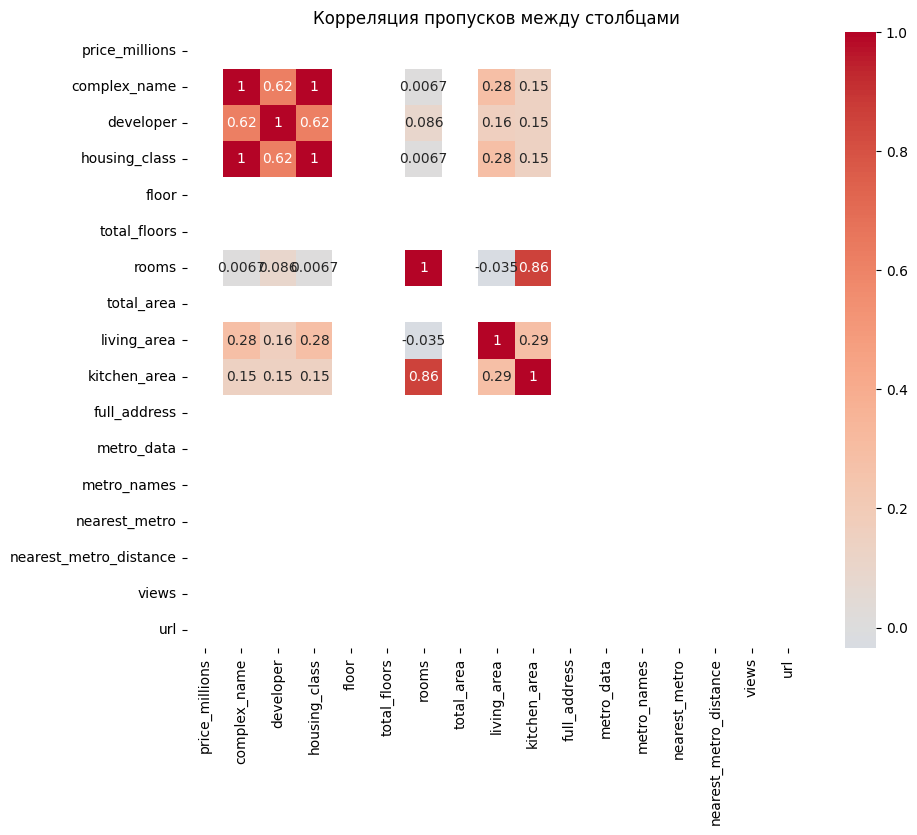

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

missing_pattern = df.isna().astype(int)
correlation_matrix = missing_pattern.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция пропусков между столбцами')
plt.show()

Разделяем адрес на четыре части: город, округ, район и все остальное

In [ ]:
import re
import pandas as pd

def smart_split_address_regex(address):
    if pd.isna(address):
        return [None] * 4

    # Разбиваем по запятым, но учитываем возможные пробелы
    parts = re.split(r'\s*,\s*', address.strip())

    # Обработка как в оригинальной функции
    if len(parts) < 4:
        parts.extend([None] * (4 - len(parts)))
        return parts[:4]
    elif len(parts) > 4:
        return parts[:3] + [', '.join(parts[3:])]
    else:
        return parts

# Применяем функцию
df[['city', 'okrug', 'district', 'other']] = df['full_address'].apply(
    lambda x: pd.Series(smart_split_address_regex(x))
)
df.sample(3)

,price_millions,complex_name,developer,housing_class,floor,total_floors,rooms,total_area,living_area,kitchen_area,...,metro_data,metro_names,nearest_metro,nearest_metro_distance,views,url,city,okrug,district,other
id,,,,,,,,,,,,,,,,,,,,,
9281390369,15.45,ЖК N`ICE LOFT (Найс Лофт),COLDY,Бизнес класс,14.0,21.0,1.0,44.84,11.94,17.57,...,"[{'name': 'Волгоградский проспект', 'distance_...","['Волгоградский проспект', 'Площадь Ильича', '...",Волгоградский проспект,1000.0,34.0,https://move.ru/objects/prodaetsya_1-komnatnay...,Москва,ЮВАО,Нижегородский район,"ул. Скотопрогонная, 4"
9284210882,18.07,ЖК «Бестселлер»,Bazis Development,Бизнес класс,4.0,29.0,1.0,40.70,10.60,18.80,...,"[{'name': 'Нижегородская', 'distance_m': 2000}...","['Нижегородская', 'Стахановская', 'Авиамоторна...",Нижегородская,2000.0,22.0,https://move.ru/objects/prodaetsya_1-komnatnay...,Москва,ЮВАО,Нижегородский район,"ул. Басовская, 1"
9280525230,27.17,ЖК SEZAR CITY,Sezar Group,Бизнес класс,40.0,51.0,1.0,45.67,13.77,17.53,...,"[{'name': 'Хорошёвская', 'distance_m': 1000}, ...","['Хорошёвская', 'Полежаевская', 'Беговая', 'Мо...",Хорошёвская,1000.0,14.0,https://move.ru/objects/prodaetsya_1-komnatnay...,Москва,2-й Хорошевский проезд,3,None


После разделения видим, что не везде была одинаковая запись адресса, на основе округов удалим все те, что не входят в список настроящих округов, данных строк достаточно мало, поэтому даже не боимся их удалять

In [ ]:
df['okrug'].unique()

array(['ЦАО', 'СЗАО', 'ЮАО', 'ЗАО', 'ВАО', 'ЮВАО',
       '3-й Силикатный проезд', 'САО', 'СВАО', 'ЮЗАО',
       '2-й Силикатный пр-д', '2-й Хорошевский проезд', None,
       'ул. Петра Алексеева', 'Лобачевская', 'Братьев Весниных бульвар',
       'проезд Мукомольный', 'ул. Академика Королева',
       'Востряковское шоссе', 'ул. Малышева', 'пр-кт Кутузовский',
       'наб Пресненская', '8-я улица Соколиной Горы',
       'ул. Советской Армии', 'ул. Донецкая', 'ул. Южнопортовая',
       'ул. Заозёрная', 'ул. Адмирала Макарова', 'ул. Ясеневая',
       'проезд Астрадамский', 'ул. Шарикоподшипниковская',
       'ул. Ярцевская', 'ул. Намёткина',
       'проезд Старо-Петровско-Разумовский'], dtype=object)

In [ ]:
valid_okrugs = ['ЦАО', 'СЗАО', 'ЮАО', 'ЗАО', 'ВАО', 'ЮВАО', 'САО', 'СВАО', 'ЮЗАО']

# Фильтруем
df_filtered = df[df['okrug'].isin(valid_okrugs)]

print(f"\nВсего строк до: {len(df)}")
print(f"Строк после: {len(df_filtered)}")
print(f"Удалено строк: {len(df) - len(df_filtered)}")


Всего строк до: 10907
Строк после: 10529
Удалено строк: 378


In [ ]:
df = df_filtered

Остались пропуски в застройщике, часть которых мы заполним далее, для всех остальных пропусков мы заполним значением "вторичка", а other вообще удалим

In [ ]:
df.isna().sum()

,0
price_millions,0
complex_name,592
developer,1402
housing_class,592
floor,0
total_floors,0
rooms,0
total_area,0
full_address,0
metro_data,0


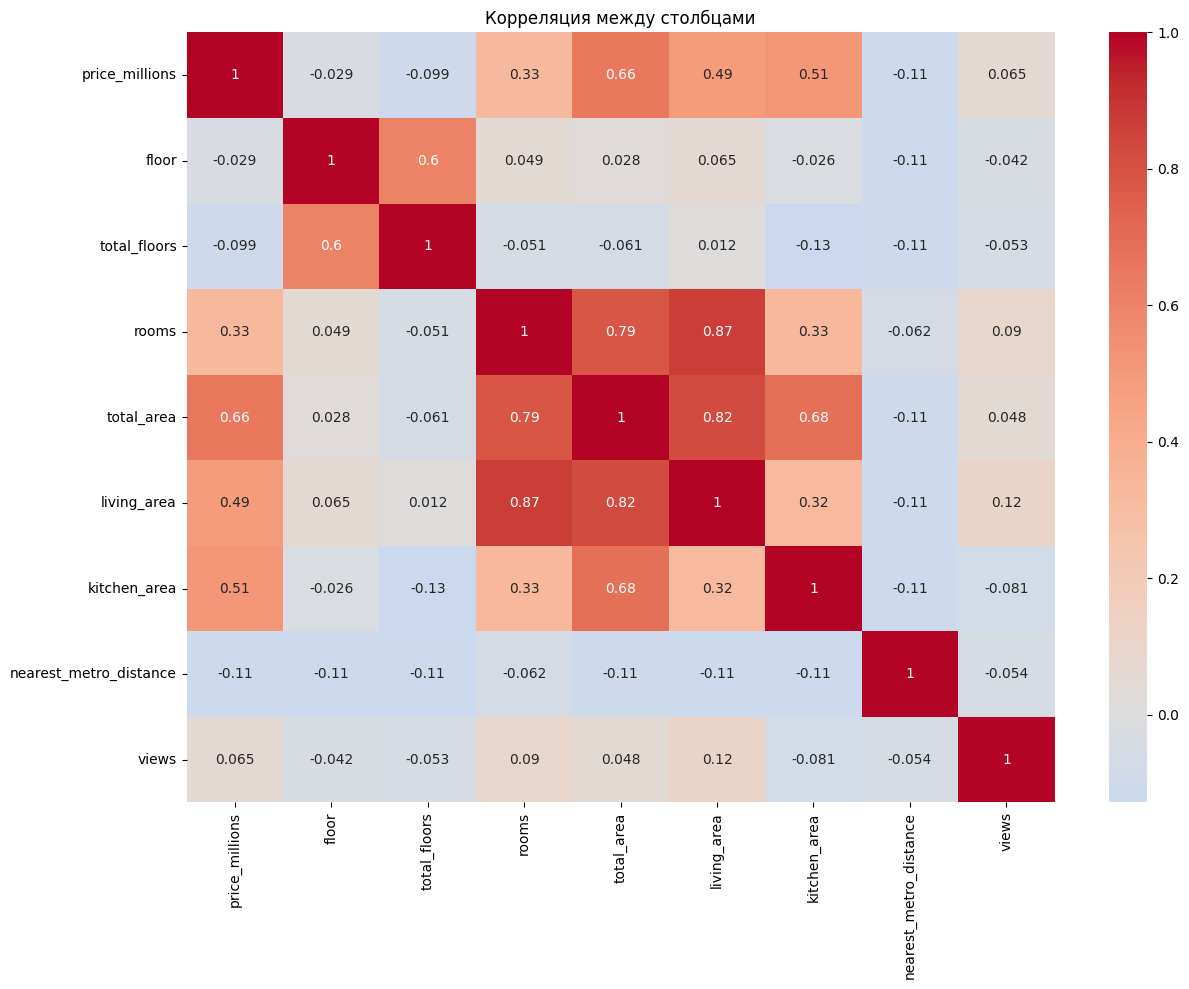

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция между столбцами')
plt.show()